# Check issues found on rounding mapspam data

- Check issues found on rounding mapspam with gdal
- Check how that affects the data translation to h3
- check how that affects the calculation of impacts

Let's start with just a commodity:

- Barley: spam2010V2r0_global_BARL_A

In [83]:
#import libraries
import rasterio as rio

from h3ronpy import raster
import numpy as np

import geopandas as gpd

In [89]:
def convert_rasterToH3(raster_path, resolution=6):
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

        gdf.plot('value')
        gdf['h3index'] = gdf['h3index'].apply(hex)
    return gdf

In [3]:
!ls ../../datasets/raw/commodities/spam2010V2r0_global_BARL_A.tif

spam2010V2r0_global_BARL_A.tif


## 1. Original raster

- Original raster
- just cliped to AOI, not rounded

In [7]:
#clip raster to extent
!gdal_translate -projwin -18.16152763 43.79152679 4.3281951 27.63736153 -a_nodata -1.0 -of GTiff ../../datasets/raw/commodities/spam2010V2r0_global_BARL_A.tif ../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
#gdal info to check projection and no data values
!gdalinfo -hist ../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif
Size is 270, 194
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-18.167314000000005,43.833517999999998)
Pixel Size = (0.083333000000000,-0.083333000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -18.1673140,  43.8335180) ( 18d10' 2.33"W, 43d50' 0.66"N)
Lower Left  ( -18.1673140,  27.6669160) ( 18d10' 2.33"W

In [85]:
#check original raster rounding

with rio.open('../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif') as src:
    arr = src.read(1)

In [87]:
print(np.max(arr))
print(np.min(arr[arr > 0]))

4351.1
0.1


,h3index,value,geometry
0,0x86398cab7ffffff,744.000000,"POLYGON ((-6.59470 32.73502, -6.63163 32.72004..."
1,0x863828d1fffffff,355.899994,"POLYGON ((1.03076 36.14502, 1.02344 36.11099, ..."
2,0x86394349fffffff,355.899994,"POLYGON ((3.23533 39.64260, 3.22671 39.60883, ..."
3,0x863828c4fffffff,286.100006,"POLYGON ((1.37535 36.10090, 1.36789 36.06683, ..."
4,0x863828c5fffffff,286.100006,"POLYGON ((1.32968 36.05427, 1.32224 36.02020, ..."


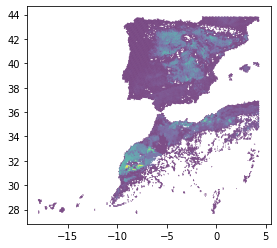

In [107]:
raster_path_no_round = '../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif'

h3_gdf = convert_rasterToH3(raster_path_no_round, resolution=6)
#h3_nr_gdf.to_file('../../datasets/raw/commodities/spam2010V2r0_global_BARL_A__clip_v1_h3.shp')
h3_gdf.head()

In [108]:
#check max value of converted raster to h3
print(h3_gdf['value'].max())
print(h3_gdf[h3_gdf['value']>0]['value'].min())

4351.10009765625
0.10000000149011612


## 2. Rounded raster

### Round 0

In [95]:
# round material
!gdal_calc.py --quiet --NoDataValue=-1 --calc="numpy.round(A)" \
-A '../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif' \
--outfile='../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip_round_0_v1.tif'

,h3index,value,geometry
0,0x86398ec67ffffff,1870.0,"POLYGON ((-7.45957 31.56976, -7.49609 31.55434..."
1,0x86380d947ffffff,125.0,"POLYGON ((3.12020 34.84953, 3.11207 34.81519, ..."
2,0x86380d957ffffff,125.0,"POLYGON ((3.07352 34.80325, 3.06542 34.76892, ..."
3,0x86380dcc7ffffff,125.0,"POLYGON ((2.83790 34.25227, 2.82995 34.21792, ..."
4,0x86380dcdfffffff,125.0,"POLYGON ((2.86018 34.19549, 2.85222 34.16113, ..."


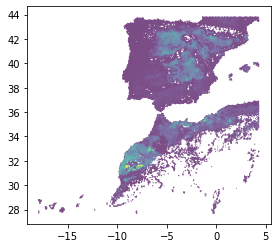

In [109]:
raster_path_no_round = '../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip_round_0_v1.tif'

h3_gdf = convert_rasterToH3(raster_path_no_round, resolution=6)
#h3_nr_gdf.to_file('../../datasets/raw/commodities/spam2010V2r0_global_BARL_A__clip_v1_h3.shp')
h3_gdf.head()

In [110]:
with rio.open('../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip_round_0_v1.tif') as src:
    arr = src.read(1)

In [111]:
print(np.max(arr))
print(np.min(arr[arr > 0]))

4351.0
1.0


In [112]:
#check max value of converted raster to h3
print(h3_gdf['value'].max())
print(h3_gdf[h3_gdf['value']>0]['value'].min())

4351.0
1.0


### Round 3

In [102]:
!gdal_calc.py --quiet --NoDataValue=-1 --calc="numpy.round(A,3)" \
-A '../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip.tif' \
--outfile='../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip_round_3_v2.tif'

,h3index,value,geometry
0,0x863982177ffffff,1434.699951,"POLYGON ((-9.65033 30.99485, -9.68679 30.97863..."
1,0x863970a0fffffff,841.799988,"POLYGON ((-0.33894 41.77714, -0.37931 41.76619..."
2,0x863970a1fffffff,841.799988,"POLYGON ((-0.38656 41.73262, -0.42691 41.72165..."
3,0x863971147ffffff,841.799988,"POLYGON ((0.68015 41.76593, 0.64005 41.75540, ..."
4,0x86397114fffffff,841.799988,"POLYGON ((0.75264 41.75365, 0.71256 41.74314, ..."


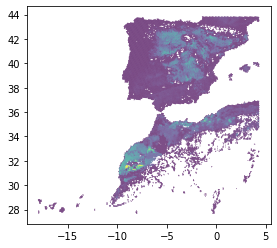

In [103]:
raster_path_no_round = '../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip_round_3_v2.tif'

h3_gdf = convert_rasterToH3(raster_path_no_round, resolution=6)
#h3_nr_gdf.to_file('../../datasets/raw/commodities/spam2010V2r0_global_BARL_A__clip_v1_h3.shp')
h3_gdf.head()

In [104]:
with rio.open('../../datasets/raw/commodities/spam2010V2r0_global_BARL_A_clip_round_3_v2.tif') as src:
    arr = src.read(1)

In [105]:
print(np.max(arr))
print(np.min(arr[arr > 0]))

4351.1
0.1


In [106]:
#check max value of converted raster to h3
print(h3_gdf['value'].max())
print(h3_gdf[h3_gdf['value']>0]['value'].min())

4351.10009765625
0.10000000149011612
